# Importar librerías

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import warnings
import statsmodels.api as sm
from matplotlib import pylab as plt
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_log_error , mean_squared_error
import sys
sys.setrecursionlimit(5000)

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

def set_seed(seed=42):
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
set_seed()

pd.set_option("display.width", 100)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 20)

print("setup-complete!")

setup-complete!


# Funciones

In [3]:
def missing_zero_values_table(df):
    """
    Obtener tabla resumen de valores ceros y faltantes en cada columna
    
    Parámetros
    ----------
    df : DataFrame
        
    Regresa
    -------
    mz_table : Dataframe
        Regresa la tabla resumen con valores faltantes y ceros
    """
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mz_table = pd.concat([zero_val, mis_val], axis=1)
    mz_table = mz_table.rename(
    columns = {0 : 'Valores Cero', 1 : 'Valores missing'})
    mz_table['Valores cero y missing'] = mz_table['Valores Cero'] + mz_table['Valores missing']
    mz_table['% de cero y missing'] = 100 * mz_table['Valores cero y missing'] / len(df)
    mz_table['Tipo de dato'] = df.dtypes
    mz_table = mz_table.sort_values(
    '% de cero y missing', ascending=False).round(3)
    print ("El dataframe seleccionado tiene " + str(df.shape[1]) + " columnas y " + str(df.shape[0]) + " filas.\n"      
        "Hay " + str(mz_table.shape[0]) +
            " columnas que no tienen valores vacíos.")
    return mz_table

In [13]:
def univariate_analysis(data, color, title1, title2):
    
    """
    Mostrando visualización de análisis univariado
    con displot y qqplot, visualización 
    de seaborn y statsmodel
    
    Parámetros
    ----------
    data : DataFrame o array
        Dataset para plotear. 
    title1: Titulo para displot
    title2: Titulo para quantilplit
        
    Regresa
    -------
    fig : matplotlib figure
        Regrse una figura con los dos gráficos
    """
    
    fig, (ax1, ax2) = plt.subplots(
        ncols=2,
        nrows=1,
        figsize=(20, 6)
    )

    sns.distplot( 
        data,
        ax=ax1,
        kde=True,
        color=color 
    )
    
    ax1.set_title(
        title1, 
        weight="bold",
        fontname="monospace", 
        fontsize=25, 
        pad=30 
    )
    
    qqplot( 
        data, 
        ax=ax2, 
        line='s' 
    )
    
    ax2.set_title( 
        title2, 
        weight="bold", 
        fontname="monospace", 
        fontsize=25, 
        pad=30 
    )
    
    return fig 

# Leer Dataset

In [4]:
df=pd.read_csv('1. New york taxi.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# EDA

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Tenemos 4 columnas de tipo float, 3 de tipo entero y 4 de tipo objeto

In [5]:
missing_zero_values_table(df)

El dataframe seleccionado tiene 11 columnas y 1458644 filas.
Hay 11 columnas que no tienen valores vacíos.


,Valores Cero,Valores missing,Valores cero y missing,% de cero y missing,Tipo de dato
passenger_count,60,0,60,0.004,int64
id,0,0,0,0.000,object
vendor_id,0,0,0,0.000,int64
pickup_datetime,0,0,0,0.000,object
dropoff_datetime,0,0,0,0.000,object
pickup_longitude,0,0,0,0.000,float64
pickup_latitude,0,0,0,0.000,float64
dropoff_longitude,0,0,0,0.000,float64
dropoff_latitude,0,0,0,0.000,float64
store_and_fwd_flag,0,0,0,0.000,object


* Se observa que hay registros que contienen 0 en el número de pasajeros, lo cual podría ser considerado un outlier ya que un viaje en taxi tiene que contener al menos un pasajero.
* No se observa valores nulos

Se convierte la variable fecha en formato fecha para obtener componentes temporales e incluirlos dentro del modelo

In [3]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_min'] = df['pickup_datetime'].dt.minute
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday

df['dropoff_min'] = df['dropoff_datetime'].dt.minute
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
df['log_trip_duration']=np.log(df['trip_duration'])

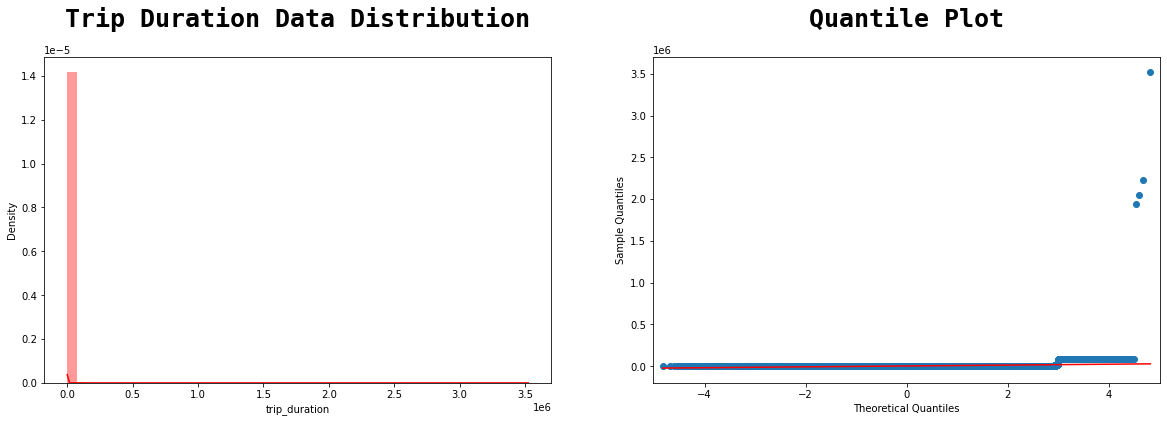

In [14]:
univariate_analysis( 
    data=df["trip_duration"], 
    color="red", 
    title1="Trip Duration Data Distribution", 
    title2="Quantile Plot")

El histograma es asimétrico y no sigue una distribución normal por el gráfico de la izquierda

In [7]:
print('Media trip duration',np.mean(df["trip_duration"]))
print('Std trip duration',np.std(df["trip_duration"]))
lim_inf=np.mean(df["trip_duration"])-2*np.std(df["trip_duration"])
lim_sup=np.mean(df["trip_duration"])+2*np.std(df["trip_duration"])
print('Limite inferior',lim_inf)
print('Limite superior',lim_sup)

Media trip duration 959.4922729603659
Std trip duration 5237.429929188969
Limite inferior -9515.367585417573
Limite superior 11434.352131338304


***Interpretación:***

Siguiendo el teorema de Chebychev al menos en el $75$% de la duración de los viajes en nueva york se tiene una duración de casi 3 horas

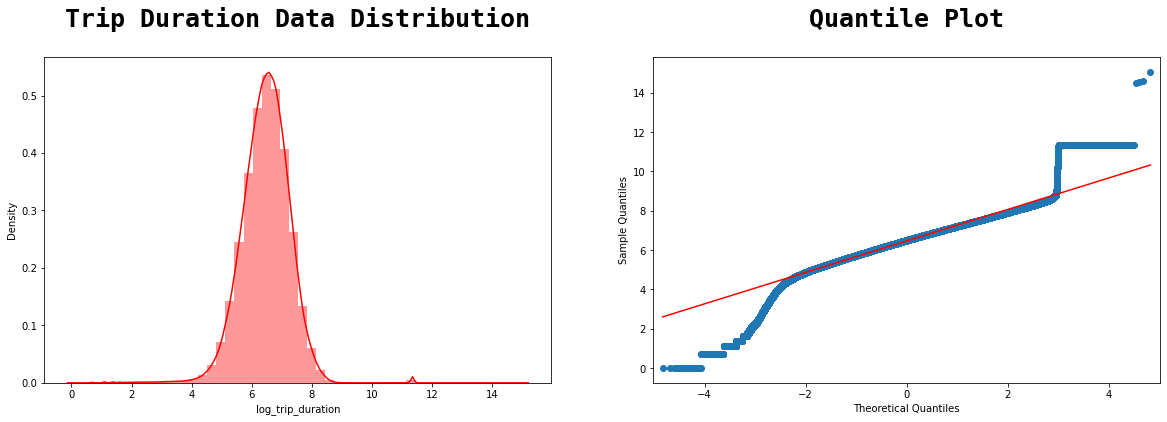

In [17]:
univariate_analysis( 
    data=df["log_trip_duration"], 
    color="red", 
    title1="Trip Duration Data Distribution",
    title2="Quantile Plot")

Si a la variable de trip duration se saca su logaritmo, se va a acercar a una distribución normal la distribución de la variable

<Figure size 1440x360 with 0 Axes>

<AxesSubplot:xlabel='passenger_count'>

Text(0.5, 1.0, 'Passenger Count Distribution')

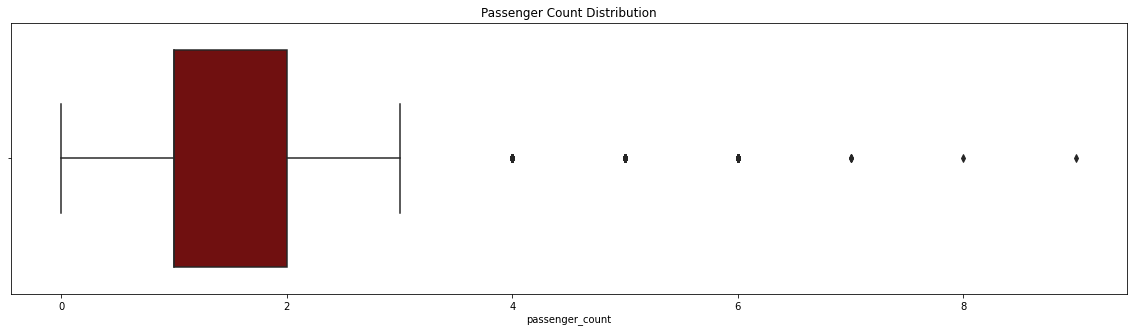

In [28]:
plt.figure(figsize=(20,5))
sns.boxplot(df['passenger_count'], color='maroon')
plt.title('Passenger Count Distribution')

A partir de este diagrama de caja se observa que la variable de cantidad de pasajeros tiene valores outliers y son aquellos que superan el valor de 4. Al mismo tiempo, se sigue observando que se tiene valores 0. Se podría probar entrenar el modelo sin los outliers y los 0

## Generación de reporte de pandas profilling

El siguiente reporte que se genera, nos brinda un overview de cada variable y su dsitribución ya se variable categórica, fecha o numérica. Al mismo tiempo, se puede visualizar las interacciones con la variable objetivo que es trip duration. Por último, se observa un gráfico de correlación para determinar la relación entre las variables.

In [24]:
profile=df.iloc[:500000].profile_report(
    title='Data Profile',
    correlations={'spearman':{'calculate':True},
                 'pearson':{'calculate':True}},
    interactions={'targets':['trip_duration','log_trip_duration'],'continuous':True},
)

In [25]:
profile.to_file('df_profile.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 73.50it/s]


In [30]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_weekday,dropoff_min,dropoff_hour,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,14,3,17,24,0,32,17,6.120297
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,12,6,0,43,6,54,0,6.496775
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,19,1,11,35,1,10,12,7.661056
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6,4,19,32,2,39,19,6.061457
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,26,3,13,30,5,38,13,6.075346


# Data Preprocessing

Las variables categóricas son tratadas con <code>get_dummies</code> para crear nuevas columnas y estas se activen si la fila presenta el valor del nombre de la columna

In [4]:
df=pd.get_dummies(df,prefix=['vendor_id','store_and_fwd_flag'], columns = ['vendor_id','store_and_fwd_flag'], drop_first=True)

La variable X contendrá todas las variables menos la variable target(original y su logaritmo), la variable fecha del recojo y llegada del viaje, así como los componentes temporales respecto a la llegada pues forman parte indirectamente del target.
<br><br>

Mientras que la variable y, para este ejercicio si se toma el logaritmo aprovechando la distribución que se genera al aplicar la transformación

In [15]:
X = df.drop(columns=['log_trip_duration','trip_duration','id','pickup_datetime','dropoff_datetime','dropoff_min','dropoff_hour'])
y = df['log_trip_duration']

Se estandariza las variables independientes para que estén a la misma escala

In [16]:
cols = X.columns

ss = StandardScaler()

new_df = ss.fit_transform(X)
new_df = pd.DataFrame(new_df, columns=cols)
new_df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_weekday,vendor_id_2,store_and_fwd_flag_Y
0,-0.505637,-0.122261,0.517494,0.124369,0.384575,-0.172813,-0.307440,0.530263,-0.322670,-1.561062,0.932380,-0.074471
1,-0.505637,-0.097727,-0.375819,-0.368970,-0.575303,-0.402616,1.477173,-2.126116,0.774030,1.509502,-1.072524,-0.074471
2,-0.505637,-0.078143,0.395910,-0.451805,-1.162220,0.401692,-1.497182,-0.407283,0.312262,-1.049301,0.932380,-0.074471
3,-0.505637,-0.515558,-0.941274,-0.549976,-1.256071,-1.092023,0.287431,0.842778,0.139099,-0.537541,0.932380,-0.074471
4,-0.505637,0.006112,1.286091,0.006974,0.855957,1.206001,-0.307440,-0.094768,0.023657,0.997741,0.932380,-0.074471


Se divide en train y test para realizar validaciones

In [17]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y, test_size=0.30, random_state=0)

# Feature Selection

<code>f_regression</code> permite derteminar si una variable independiente es significativa para la variable dependiente y rankea de acuerdo F-value

SelectKBest(k='all', score_func=<function f_regression at 0x000002AD0072A048>)

<BarContainer object of 12 artists>

Text(0.5, 0, 'feature index')

Text(0, 0.5, 'F-value (transformed from the correlation values)')

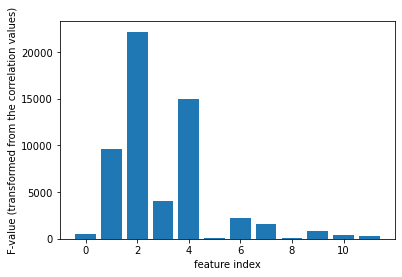

In [18]:

f_selector = SelectKBest(score_func=f_regression, k='all')

f_selector.fit(X_train, y_train)

X_train_fs = f_selector.transform(X_train)

X_test_fs = f_selector.transform(X_test)

plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel("feature index")
plt.ylabel("F-value (transformed from the correlation values)")
plt.show()

Se observa que la variable en el índice 1,2 y 4 tienen mayor relación

Así como el método anterior, <code>mutual_info_regression</code> permite verificar si existe una relación de dependencia entre dos variables: en este caso con la variable y. Esta función tiene como base un método no paramétrico.

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x000002AD0079DE58>)

<BarContainer object of 12 artists>

Text(0.5, 0, 'feature index')

Text(0, 0.5, 'Estimated MI value')

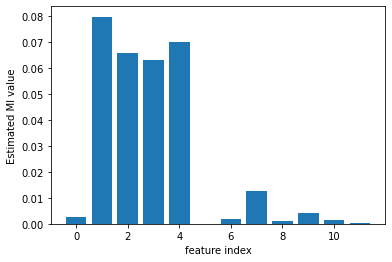

In [19]:

f_selector = SelectKBest(score_func=mutual_info_regression, k='all')

f_selector.fit(X_train, y_train)

X_train_fs = f_selector.transform(X_train)

X_test_fs = f_selector.transform(X_test)

plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel("feature index")
plt.ylabel("Estimated MI value")
plt.show()

Se observa que la variable en el índice 1,2,3 y 4 tienen mayor relación

Se utiliza el método de OLS (Mínimos cuadrados ordinarios) para validar si existe una relación de dependencia entre las variables independientes y dependiente.

In [21]:

X_1 = sm.add_constant(X_train)

model = sm.OLS(y_train,X_1).fit()
model.pvalues

const                    0.000000e+00
passenger_count          4.766858e-59
pickup_longitude         0.000000e+00
pickup_latitude          0.000000e+00
dropoff_longitude        1.218280e-07
dropoff_latitude         0.000000e+00
pickup_day               5.179154e-23
pickup_month             0.000000e+00
pickup_hour              0.000000e+00
pickup_min               3.561479e-20
pickup_weekday          9.439555e-179
vendor_id_2              8.155610e-62
store_and_fwd_flag_Y     5.373019e-49
dtype: float64

Todas las variables tienen un pvalue menor a 0.5 por lo que son significativas para el modelo

Por útlimo, probamos el con método de **backward elimination** que busca eliminar las variables que menos aportan a explicar la variable dependiente 

In [22]:

cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_day', 'pickup_month', 'pickup_hour', 'pickup_min', 'pickup_weekday', 'vendor_id_2', 'store_and_fwd_flag_Y']


No se llega a eliminar ninguna variable

# Entrenamiento de modelos

Utilizaremos las siguientes métricas para comparar los modelos:
* R2
* RMSLE

## Regresión lineal

In [23]:
model=LinearRegression()
model.fit(X_train,y_train)
pred=model.predict(X_test)

LinearRegression()

In [27]:
#examining scores

print ("Training Score : " , model.score(X_train, y_train))

print ("Validation Score : ", model.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(model, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(pred, y_test))

#print ("RMSLE : ", np.sqrt(mean_squared_log_error(pred, y_test)))

Training Score :  0.041708579701428494
Validation Score :  0.04838363060798523
Cross Validation Score :  0.03757497363927202
R2_Score :  -24.78948534421084


## Árbol de decisión

In [28]:
from sklearn.tree import DecisionTreeRegressor

est_dt = DecisionTreeRegressor(criterion="mse", max_depth=10)
est_dt.fit(X_train, y_train)
dt_pred = est_dt.predict(X_test)

DecisionTreeRegressor(criterion='mse', max_depth=10)

array([6.45031806, 7.25884   , 7.33326361, ..., 5.91509524, 6.06218892,
       5.98143875])

In [29]:
print ("Training Score : " , est_dt.score(X_train, y_train))

print ("Validation Score : ", est_dt.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_dt, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(dt_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(dt_pred, y_test)))

Training Score :  0.45548546860329897
Validation Score :  0.45018851293072293
Cross Validation Score :  0.44367918388137806
R2_Score :  -0.19917211987414496
RMSLE :  0.08841038342849017


## Bosque aleatorio

In [30]:
from sklearn.ensemble import RandomForestRegressor

est_rf = RandomForestRegressor(criterion="mse", n_estimators=50, max_depth=10)
est_rf.fit(X_train, y_train)
rf_pred = est_rf.predict(X_test)

RandomForestRegressor(criterion='mse', max_depth=10, n_estimators=5)

array([6.43314441, 7.31403654, 7.50859704, ..., 5.90121521, 6.77135327,
       5.93317291])

In [31]:
print ("Training Score : " , est_rf.score(X_train, y_train))

print ("Validation Score : ", est_rf.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_rf, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(rf_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(rf_pred, y_test)))

Training Score :  0.472558241652824
Validation Score :  0.46908472619373986
Cross Validation Score :  0.47019494313907534
R2_Score :  -0.18953756842584202
RMSLE :  0.08705871522695947


## Lightgbm Regressor

In [35]:
model = lgb.LGBMRegressor(boosting_type= 'gbdt',objective= 'mse',metric= 'mse',
    n_estimators= 50,random_state=1)
model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],verbose=False)
pred = model.predict(X_test) 

LGBMRegressor(metric='mse', n_estimators=50, objective='mse', random_state=1)

In [36]:
print ("Training Score : " , model.score(X_train, y_train))

print ("Validation Score : ", model.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(model, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(pred, y_test)))

Training Score :  0.5535562844120776
Validation Score :  0.5554312007799898
Cross Validation Score :  0.5550509807266366
R2_Score :  -0.06394544238009225
RMSLE :  0.08119237053583579


Se observa que el modelo de lightgbm es más rápido que los otros modelos y en cuanto a métricas se tiene resultados aceptables en comparación a los otros. Con esto pasamos a la etapa de optimización de hiperparámetros.